In [1]:
import pickle
import os
from typing import Dict, Any
from matplotlib import pyplot as plt
import numpy as np

import plotly.express as px
import pandas as pd


In [2]:
regular_sims_dir = os.path.join(os.getcwd(), "..\sim_res\\regular")
global_not_nash_sims_dir = os.path.join(os.getcwd(), "..\sim_res\global_is_not_nash")
no_nash_sims_dir = os.path.join(os.getcwd(), "..\sim_res\\no_nash")

In [3]:
def collect_opt_gaps(sims_dir):
    nash_policies_opt_gaps_per_sim = []
    opt_vals = []
    stds = []
    for sim_pkl in os.listdir(sims_dir):
        sim_fullpath = os.path.join(sims_dir, sim_pkl)
        with open(sim_fullpath, 'rb') as f:
            sim_data = pickle.load(f)
        nash_opt_gaps = sim_data['nash_opt_gaps']
        opt_val = np.mean(sim_data['simulation'].multi_agent.value_function)
        stds.append(np.std(sim_data['simulation'].multi_agent.value_function))
        opt_vals.append(opt_val)
        nash_policies_opt_gaps_per_sim.append(nash_opt_gaps)
    return nash_policies_opt_gaps_per_sim, opt_vals, stds


def plot_relative_optimality_gaps(opt_gaps_per_sim, sims_opt_vals):
    simulation_ids = []  # Simulation index for each point
    gaps = []  # Optimality gap for each point
    for sim_idx, (gaps_list, opt_val) in enumerate(zip(opt_gaps_per_sim, sims_opt_vals)):
        simulation_ids.extend([sim_idx + 1] * len(gaps_list))  # Assign a simulation index to each gap
        gaps.extend([g / opt_val for g in gaps_list])
        
    data = pd.DataFrame({
        "simulation": simulation_ids,
        "relative_optimality_gap": gaps
    })
    
    # Create scatter plot
    fig = px.scatter(data, x="simulation", y="relative_optimality_gap", title='Relative Optimality Gaps for Nash Policies Across Simulations')
    fig.show()

    # Create agg hist plot
    fig2 = px.ecdf(data, x="relative_optimality_gap",
                        title='Flattened Histogram - Relative Optimality Gaps for Nash Policies Across Simulations')
    fig2.show()

def plot_quantile_optimality_gap_hist(opt_gaps_per_sim, sims_opt_vals, q=0.5):
    simulation_ids = []  # Simulation index for each point
    sim_q_gaps = []  # Optimality gap for each point
    for sim_idx, (gaps_list, opt_val) in enumerate(zip(opt_gaps_per_sim, sims_opt_vals)):
        simulation_ids.append(sim_idx + 1)  # Assign a simulation index to each gap
        relative_gaps = [g / opt_val for g in gaps_list]
        sim_q_gaps.append(np.quantile(relative_gaps, q))
        
    data = pd.DataFrame({
        "simulation": simulation_ids,
        f"qauntile_{q}_optimality_gap": sim_q_gaps
    })

    fig = px.histogram(data, x=f"qauntile_{q}_optimality_gap", nbins=20, title=f"Histogram of Quantile {q} gaps")
    # Customize layout
    fig.update_layout(xaxis_title="Quantile Optimality Gap", yaxis_title="Frequency", barmode="overlay")
    fig.update_traces(opacity=0.6)
    fig.show()
    

# Optimal Nash Sims - Analysis

In [77]:
# Prepare data for scatter plot
nash_policies_opt_gaps_per_sim, opt_vals, stds = collect_opt_gaps(regular_sims_dir)


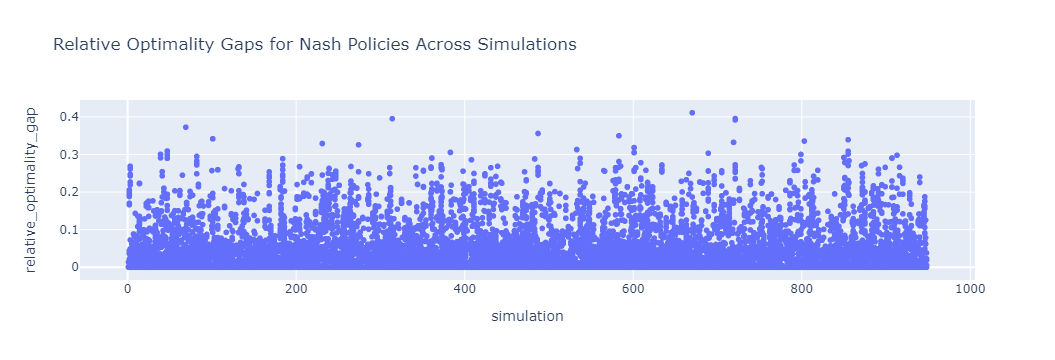

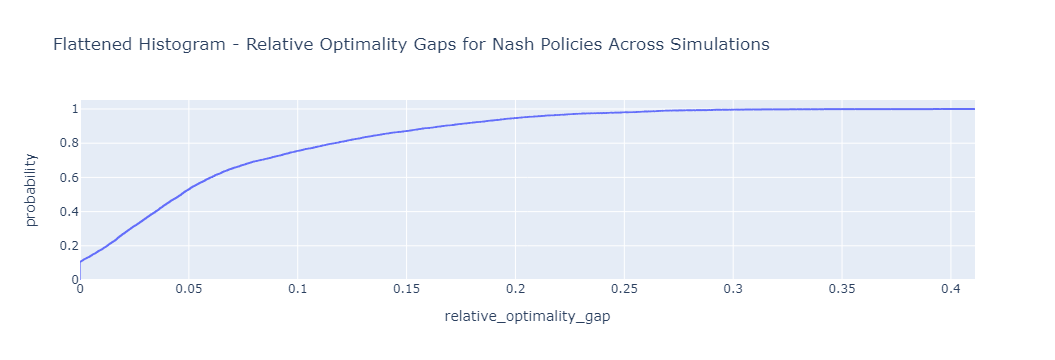

In [78]:
# plot optimality gap for different classes of simulations
plot_relative_optimality_gaps(nash_policies_opt_gaps_per_sim, opt_vals)


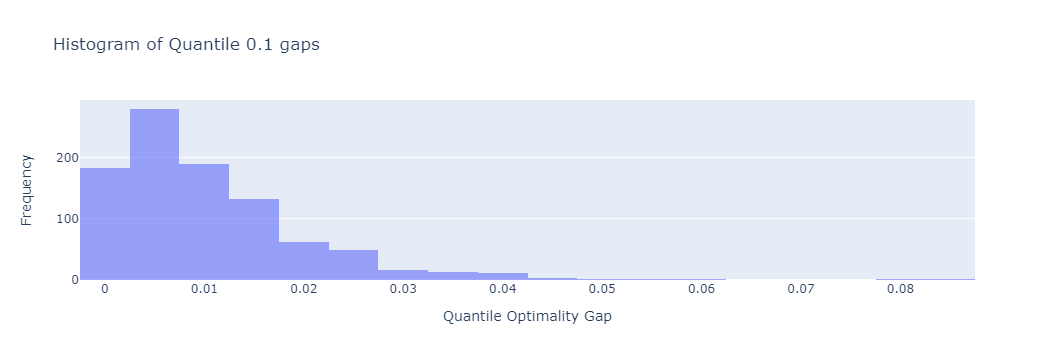

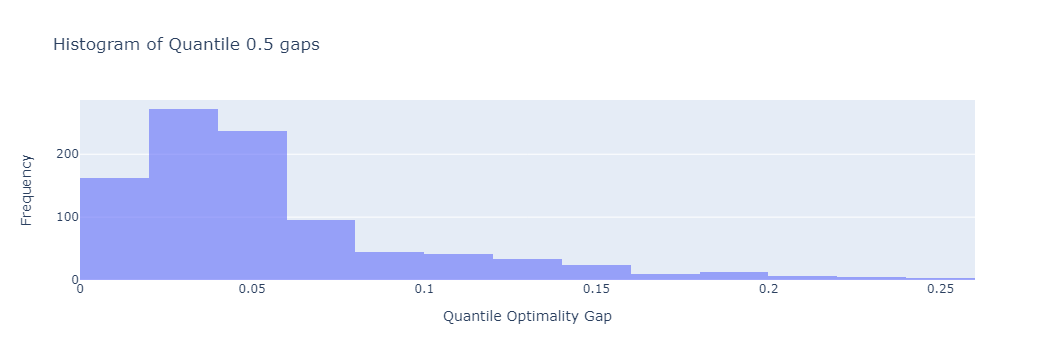

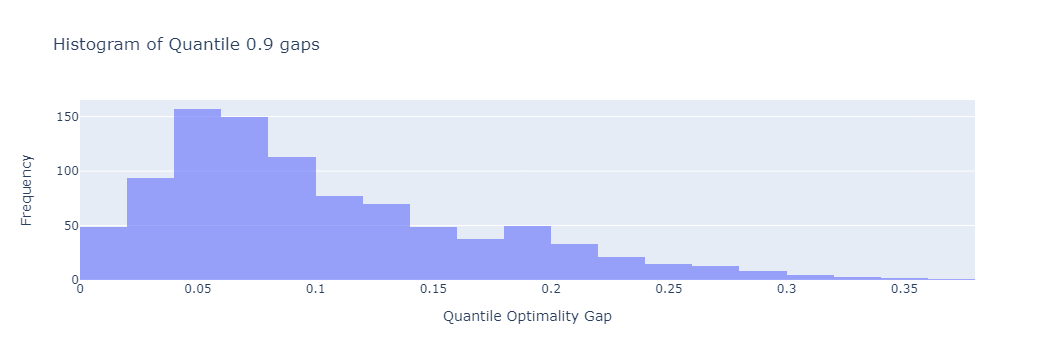

In [79]:
plot_quantile_optimality_gap_hist(nash_policies_opt_gaps_per_sim, opt_vals, q=0.1)
plot_quantile_optimality_gap_hist(nash_policies_opt_gaps_per_sim, opt_vals, q=0.5)
plot_quantile_optimality_gap_hist(nash_policies_opt_gaps_per_sim, opt_vals, q=0.9)

# No Nash sims - Analysis

In [4]:
# collect all data from those sims
def collect(sims_dir):
    sims_data_list = []
    for sim_pkl in os.listdir(sims_dir):
        sim_fullpath = os.path.join(sims_dir, sim_pkl)
        with open(sim_fullpath, 'rb') as f:
            sim_data = pickle.load(f)
        sims_data_list.append(sim_data)
        
    return sims_data_list


sims_data_list = collect(no_nash_sims_dir)


In [6]:
simulation = sims_data_list[0]['simulation']
all_policies = simulation.multi_agent.get_all_deterministic_policies(states=simulation.multi_agent.get_joint_states(),
                                                                     actions=simulation.multi_agent.get_joint_actions())
all_val_funcs = [simulation.multi_agent.calc_value_function(joint_policy=p) for p in all_policies]
# sims_data_list[0]['simulation'].multi_agent._multi_agent_reward._u_list
# sims_data_list[3]['simulation'].multi_agent._multi_agent_reward._g

(array([24., 30., 34., 53., 23., 21., 39., 16.,  0., 16.]),
 array([2.50739646e-07, 1.09201797e+00, 2.18403569e+00, 3.27605341e+00,
        4.36807113e+00, 5.46008885e+00, 6.55210657e+00, 7.64412429e+00,
        8.73614201e+00, 9.82815973e+00, 1.09201775e+01]),
 <BarContainer object of 10 artists>)

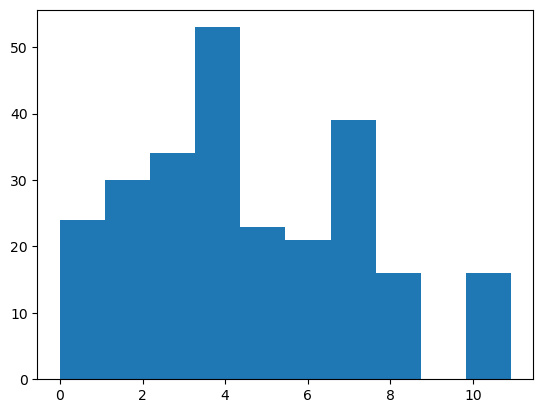

In [7]:
from RL_utils import calc_policy_gap
gaps = []
for v in all_val_funcs:
    gaps.append(calc_policy_gap(simulation.multi_agent.value_function, v))
plt.hist(gaps)

In [7]:
simulation.multi_agent.value_function

array([17.8224949 , 17.80288957, 17.66743122, 17.64782515])

In [8]:
print(sims_data_list[0]['simulation'].multi_agent._multi_agent_reward._u_list)
print(sims_data_list[0]['simulation'].multi_agent._multi_agent_reward._g)


[{(0, 0): 0.8226143185136784, (0, 1): 0.42373825364876283, (1, 0): 0.6675498992914705, (1, 1): 0.09553531383466818}, {(0, 0): 0.623859324676573, (0, 1): 0.4517676787372291, (1, 0): 0.5866084631754741, (1, 1): 0.16801420774486342}]
{(0, 0): 0.3534213793027181, (0, 1): 0.23687055897448206, (1, 0): 0.7805255152438618, (1, 1): 0.2748060355481361}


In [5]:
from reward_functions import SeperableMultiAgentReward
simulation1 = sims_data_list[0]['simulation']
simulation2 = sims_data_list[2]['simulation']
SeperableMultiAgentReward.calc_distance_between_rewards(simulation1.multi_agent._multi_agent_reward, simulation2.multi_agent._multi_agent_reward)

2.5006486501042064

# All simulations - Analysis

In [38]:
# collect all reward vectors for all simulations
no_nash_sims_data_list = collect(no_nash_sims_dir)
regular_sims_data_list = collect(regular_sims_dir)
global_not_nash_sims_data_list = collect(global_not_nash_sims_dir)

unified = []
unified.extend(no_nash_sims_data_list)
unified.extend(regular_sims_data_list)
unified.extend(global_not_nash_sims_data_list)

reward_vec_dim = len(no_nash_sims_data_list[0]['simulation'].multi_agent._multi_agent_reward.get_reward_as_vector())
reward_vecs = np.zeros((len(unified), reward_vec_dim))

counter = 0
labels = []
for i, sim_data in enumerate(no_nash_sims_data_list):
    labels.append(0)
    reward_vecs[counter + i, :] = sim_data['simulation'].multi_agent._multi_agent_reward.get_reward_as_vector()

counter += i
for i, sim_data in enumerate(regular_sims_data_list):
    labels.append(1)
    reward_vecs[counter + i, :] = sim_data['simulation'].multi_agent._multi_agent_reward.get_reward_as_vector()

counter += i
for i, sim_data in enumerate(global_not_nash_sims_data_list):
    labels.append(2)
    # print(counter + i)
    reward_vecs[counter + i, :] = sim_data['simulation'].multi_agent._multi_agent_reward.get_reward_as_vector()

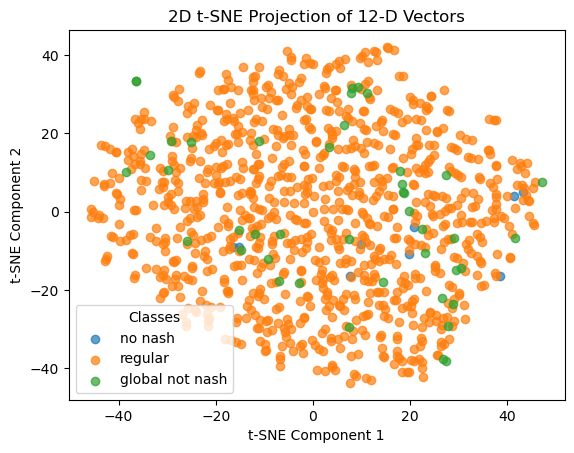

In [44]:
from sklearn.manifold import TSNE

# Reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
data_centered = reward_vecs - np.mean(reward_vecs, axis=0)
data_2d = tsne.fit_transform(data_centered)

# Plot the 2D projection
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(data_2d[idx, 0], data_2d[idx, 1], label=f"Class {label}", alpha=0.7)
    
plt.legend(['no nash', 'regular', 'global not nash'], title="Classes")
plt.title(f"2D t-SNE Projection of {reward_vec_dim}-D Vectors")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [72]:
# add more stability analysis - what makes a game be a game with no nash / global is not nash?

# find nearest neighbor of all outliers
from sklearn.neighbors import NearestNeighbors

# Initialize and fit NearestNeighbors
n_neighbors = 2
nn = NearestNeighbors(n_neighbors=n_neighbors, metric='chebyshev') # tried also l1, l2

# seems that the dimensionality is not that low...so it is rare to have similar simulations across all 12 dimensions


nn.fit(reward_vecs)

# iterate on outliers and print their neighbors and their classes
dists_per_label = {}
for label in np.unique(labels):
    idx = labels == label
    # Find the nearest neighbors
    distances, indices = nn.kneighbors(reward_vecs[idx, :])
    dists_per_label[label] = [d[1] for d in distances]

for label, dists in dists_per_label.items():
    print(f"label {label}: mean dist {np.mean(dists)}")

    # for i, label in enumerate(labels):
    
#     if label == 0: # or label == 2:
#         # Query point (find neighbors for this point)
#         query_point = np.expand_dims(reward_vecs[i, :], axis=0)
        
#         # Find the nearest neighbors
#         distances, indices = nn.kneighbors(query_point)
        
#         print("Distances:", distances[0][1:])
#         print("Indices:", indices[0][1:])
#         indices_ints = [int(i) for i in indices[0][1:]]
#         print("Neighbors labels:", [labels[i] for i in indices_ints])

label 0: mean dist 0.31321376772579324
label 1: mean dist 0.33098855288418877
label 2: mean dist 0.30599534218643554
